## **Design and Manufacturing Workflow**

1. Create a quick paper mockup of your final prototype design (you may use a prior prototype if it still applies, but you may destroy it.). Once you have arrived at your desired architecture, proceed to unfold the prototype in a way that makes sense from the perspective of optimizing material usage, staying within any boundary limitations (size of a piece of posterboard, size of the cutter you will be using).

The final prototype of our Razor Clam inspired foldable robot will consist of three sarrus mechanisms placed on top of one another. The sarrus mechanisms will be constructed from 8.5" x 11" black cardstock. The sarrus mechanisms have five holes on the top and bottom links. These holes will be used to attach 3D printed electrical housing and spring mounts. Figures 1a-1c depict a folded sarrus mechanism and two flattened sarrus mechanism (one physically drawn and one electronically drawn).  

![](https://drive.google.com/uc?export=view&id=1T-czdL0g193dsuHQ7zsa8p2S6WmOctDO)

<h0><center>**Figure 1a: Electronically Drawn Sarrus Mechanism**</center></h0>

![](https://drive.google.com/uc?export=view&id=1JxxNfc6JNgqMDn2AdQlmDozen2yPE3YQ)

<h0><center>**Figure 1b: Hand Drawn Sarrus Mechanism**</center></h0>

![](https://drive.google.com/uc?export=view&id=1W9mQSL_e77eN1eUgZI9miwDFxlDqkJox)

<h0><center>**Figure 1c: Folded Sarrus Mechanism (mounting holes were not cut out yet)**</center></h0>

2. Design the geometry of your robot in .dxf format. Convert the flattened pattern to dimensioned a Solidworks sketch. Include any mounting holes for motors, springs, or connectors. Use the Solidworks tutorial to create a hinged assembly of all parts of the design. Take a screenshot of the robot in its folded & assembled state. Flatten the assembly back to its original flattened state. Create a drawing from the assembly and use the solidworks export macro to export a yaml file (generic). Use the solidworks support functionality in foldable robotics to convert to a dxf.

Although the final prototype will consist of three sarrus mechanisms stacked on top of one another, a solidworks assembly was created only using one sarrus mechanism. The sarrus mechanism created has mounting holes where 3D printed parts will attach to. These 3D printed parts will connect the three sarrus mechanisms together. Figures 2a and 2b depict a flattened and folded Solidworks model of our robots sarrus mechanisms. Two missing joints were present when using the in-class method of retrieving the yaml file and converting it into a dxf file. We realized that this is a bug within the Foldable Robotics code. Fgure 2c shows the dxf file created. 

![](https://drive.google.com/uc?export=view&id=1lSuxHAOsDJE6lO17XSMEL2gtLIrOVpUJ)

<h0><center>**Figure 2a: Flattened Solidworks Sarrus Mechanism**</center></h0>

![](https://drive.google.com/uc?export=view&id=16R5uSoGr1R790hh0pyZ8CVMpLqO1Zcmq)

<h0><center>**Figure 2b: Folded Solidworks Sarrus Mechanism**</center></h0>

![](https://drive.google.com/uc?export=view&id=1kI7VjQcs_HLFPDGx1j2BYc0xV74InpZs)

<h0><center>**Figure 2c: .dxf File**</center></h0>

Below is the Jupyter Notebook code used to convert the Solidworks generated yaml file to a dxf file.

In [1]:
import foldable_robotics
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import shapely.geometry as sg
foldable_robotics.resolution=4

In [2]:
import foldable_robotics
import foldable_robotics.dxf 
import numpy
import shapely.geometry as sg
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics.manufacturing
import foldable_robotics.parts.castellated_hinge1
import idealab_tools.plot_tris
from math import pi, sin,cos,tan
import idealab_tools.text_to_polygons
foldable_robotics.display_height=200
foldable_robotics.line_width=.5

from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics
import foldable_robotics.dxf 
import foldable_robotics.manufacturing
import foldable_robotics.parts.castellated_hinge1
foldable_robotics.display_height=200
foldable_robotics.line_width=.5

import os
import foldable_robotics.solidworks_support

In [3]:
def get_bodies(filename, layername, num_layers):
    body = foldable_robotics.dxf.read_lwpolylines(filename,layer=layername, arc_approx = 10)

    bodies = [Layer(sg.Polygon(item)) for item in body]
    body = bodies.pop(0)
    for item in bodies:
        body ^= item
    body = body.to_laminate(num_layers)
    return body

In [4]:
def get_hinge_lines(filename,layername):
    hinge_lines1 = foldable_robotics.dxf.read_lines(filename,layer=layername)
    hinge_lines2 = foldable_robotics.dxf.read_lwpolylines(filename,layer=layername)
    hinge_lines3 = []
    for points in hinge_lines2:
        hinge_lines3.append(points[:2])
    hinge_lines = hinge_lines1 +hinge_lines3
    return hinge_lines

In [5]:
def hinge_lines_to_hinges(hinge_lines,hinge):
    lam = Layer().to_laminate(len(hinge))
    all_hinges = []    
    for p3,p4 in hinge_lines:
        all_hinges.append(hinge.map_line_stretch((0,0),(1,0),p3,p4))
    all_hinges = lam.unary_union(*all_hinges)
    return all_hinges

In [6]:
def get_cuts(filename,layername,thickness,num_layers):
    cut_lines = foldable_robotics.dxf.read_lines(filename,layer=layername)
    cut_lines += foldable_robotics.dxf.read_lwpolylines(filename,layer=layername, arc_approx = 10)
    
    cuts = []
    for item in cut_lines:
        cuts.append(Layer(sg.LineString(item)))
    cuts = Layer().unary_union(*cuts)
    cuts<<=thickness/2
    cuts = cuts.to_laminate(num_layers)
    return cuts   

In [7]:
def get_holes(filename, layername,num_layers):
    holes = foldable_robotics.dxf.read_circles(filename,layer='holes')
    
    holes2 = []
    for center, radius in holes:
        holes2.append(sg.Point(*center).buffer(radius))
    holes_layer = Layer(*holes2)
    holes_lam = holes_layer.to_laminate(num_layers)  
    return holes_lam

In [8]:
def hinge_width_calculator(desired_degrees,thickness):
    theta = (180-desired_degrees)*pi/180
    w=thickness/tan(theta)
    return w

In [9]:
def polys_to_layer(l1):
    l1 = [sg.Polygon(item) for item in l1]
    l11 = Layer(l1.pop(0))
    for item in l1:
        l11 ^= Layer(item)
    return l11

In [10]:
def output_pdf(filename,design,x,y,layers_separate = True):
    design = design.translate(x,y)
    design=design.scale(1/25.4,1/25.4)
    design=design.scale(foldable_robotics.pdf.ppi,foldable_robotics.pdf.ppi)
    if isinstance(design,Laminate):
        if not layers_separate:
            p=foldable_robotics.pdf.Page(filename+'.pdf')
            for d in design:
    #        d = design[0]
                for item in d.exteriors()+d.interiors():
                    p.draw_poly(item)
            p.close()
        else:
            for ii,d in enumerate(design):
                p=foldable_robotics.pdf.Page(filename+'{0:03f}.pdf'.format(ii))
                for item in d.exteriors()+d.interiors():
                    p.draw_poly(item)
                p.close()

    elif isinstance(design,Layer):
        p=foldable_robotics.pdf.Page(filename+'.pdf')
        for item in design.exteriors()+design.interiors():
            p.draw_poly(item)
        p.close()

In [11]:
def build_layer_numbers(num_layers, text_size = None, prop=None):
    text_size = text_size or 1
    prop = prop or {'family':'Arial','size':text_size}
    layer_ids = []
    for ii in range(num_layers): 
    
        l = idealab_tools.text_to_polygons.text_to_polygons('Layer '+str(ii),prop=prop)
        layer_ids.append(l)
    
    layer_ids = [polys_to_layer(item) for item in layer_ids]
    layer_id = Laminate(*layer_ids)
    return layer_id

In [12]:
def build_web(design,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive):
    num_layers = len(design)

    layer_id = build_layer_numbers(num_layers,text_size=jig_diameter)

    design_outer = foldable_robotics.manufacturing.unary_union(design)
    bb1= (design_outer<<jig_hole_spacing/2).bounding_box()
    (x1,y1),p2 = bb1.bounding_box_coords()
    w,h = bb1.get_dimensions()
    w2 = round(w/jig_hole_spacing)*jig_hole_spacing
    h2 = round(h/jig_hole_spacing)*jig_hole_spacing
    
    points = []
    points.append(sg.Point(x1,y1))
    points.append(sg.Point(x1+w2,y1))
    points.append(sg.Point(x1,y1+h2))
    points.append(sg.Point(x1+w2,y1+h2))
    
    layer_id = layer_id.translate(x1+jig_diameter,y1-jig_diameter/2)
    placement_holes2 = Layer(*points)
    placement_holes2<<=(jig_diameter/2)
    sheet = (placement_holes2<<10).bounding_box()
    placement_holes2=placement_holes2.to_laminate(num_layers)
    sheet=sheet.to_laminate(num_layers)
    
    removable_scrap = calculate_removable_scrap(design,sheet,support_width,is_adhesive)
    
    web = (removable_scrap-placement_holes2)-layer_id
    return web,sheet

In [13]:
def calculate_removable_scrap(design,sheet,width,is_adhesive):
    '''this computes all removable scrap given a sheet, a design, and a clearance width'''
    all_scrap = sheet-design

    ru = foldable_robotics.manufacturing.not_removable_up(design,is_adhesive)
    rd = foldable_robotics.manufacturing.not_removable_down(design,is_adhesive)
    
    removable_scrap_up = all_scrap-(ru<<width)
    removable_scrap_down = all_scrap-(rd<<width)

    removable_scrap = removable_scrap_up|removable_scrap_down
    return removable_scrap

In [14]:
folder = 'C:/Users/amarine3/Design and Manufacturing Workflow/'                     
input_filename = folder+'Sarrus Mechanism - Sheet1_Drawing View1.yaml'                            
output_file_name = 'design.dxf'

In [15]:
round_digits = 2
prescale=1000
jig_diameter = 5
support_width = 1
kerf = .05
jig_hole_spacing=20
is_adhesive1 = [False]
is_adhesive = [False,True,False,True,False]
arc_approx = 10

In [16]:
foldable_robotics.solidworks_support.process(input_filename,output_file_name,prescale,round_digits)

(<foldable_robotics.layer.Layer at 0x1352c90b970>,
  <foldable_robotics.solidworks_support.Component at 0x1352c9025e0>])

3. Using a single-layer design approach, compute the design of your device in one layer, plotting each step along the way. This should include: a one-layer hinge design that fits your team’s need (with justification for material used, rotational needs, manufacturing method used, etc), mapping the hinge design to each joint in your joints layer of the dxf, subtracting the one layer hinge design from your body layer, and holes computed for any vertices.

Generating a perforated hinge for the single layer design.

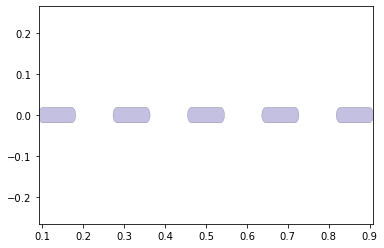

In [17]:
radius = .01
num_perforations = 5
num_segments = num_perforations*2+1
num_points = num_segments+1
a=numpy.r_[0:1:num_points*1j]
lines = []
for ii in range(int(len(a)/2)-1):
    p1 = sg.Point(a[2*ii+1]+radius,0)
    p2 = sg.Point(a[2*ii+2]-radius,0)
    lines.append(sg.LineString((p1,p2)))
hinge = Layer(*lines)
hinge<<=radius
hinge = Laminate(hinge)


w=hinge_width_calculator(150,1.1)
hinge = hinge.scale(1,w)
hinge.plot()

In [18]:
NUMLAYERS = len(hinge)
NUMLAYERS

1

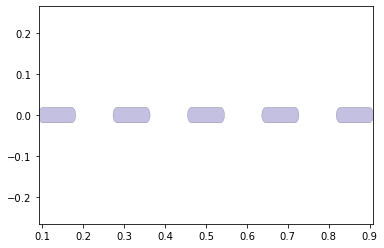

In [19]:
hinge.plot()

Generating main body of the design from the imported DXF.

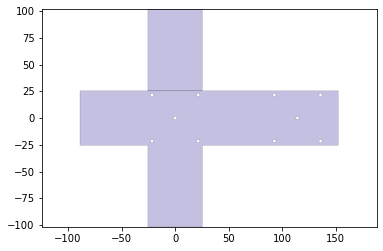

In [20]:
body = get_bodies(output_file_name,'body',NUMLAYERS)
body = foldable_robotics.manufacturing.cleanup(body,.01)
body.plot()

Perforated hinges at each joint line from the joint layer.

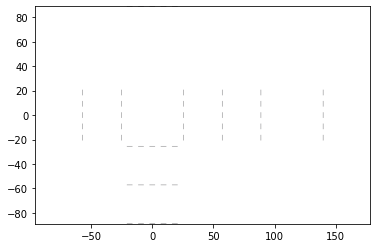

In [21]:
joint_lines= get_hinge_lines(output_file_name,'joints')
joints = hinge_lines_to_hinges(joint_lines,hinge)
joints = foldable_robotics.manufacturing.cleanup(joints,.001)
joints.plot()

In [22]:
cuts = get_cuts(output_file_name,'cuts',.02,NUMLAYERS)

In [23]:
holes = get_holes(output_file_name,'holes',NUMLAYERS)

Generating holes at vertices to prevent collision.

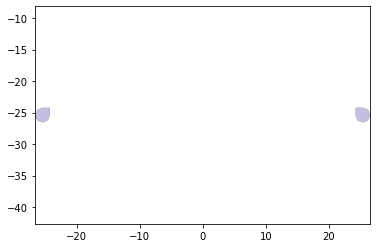

In [24]:
hole,dummy = foldable_robotics.manufacturing.calc_hole(joint_lines,w)
hole = hole.to_laminate(NUMLAYERS)
hole<<=.2
hole.plot()

End Result.

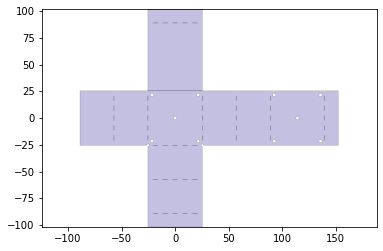

In [25]:
design = body- hole - joints - cuts - holes
design.plot()

Generating the keepout.

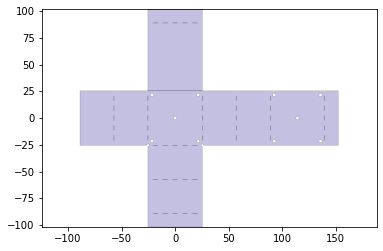

In [26]:
keepout =  foldable_robotics.manufacturing.keepout_laser(design)
keepout.plot()

Generating web and sheet generation.

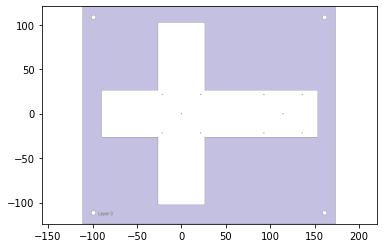

In [27]:
web,sheet=build_web(design,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive1)
web.plot()

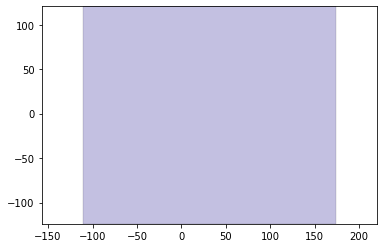

In [28]:
sheet.plot()

Because this is 1-layer, only single pass is required.

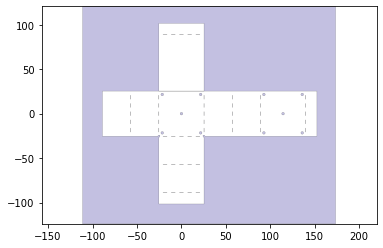

In [29]:
first_pass_scrap = sheet - design
first_pass_scrap = foldable_robotics.manufacturing.cleanup(first_pass_scrap,.00001)
first_pass_scrap.plot()

Generating support.

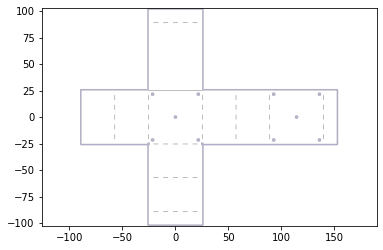

In [30]:
support = foldable_robotics.manufacturing.support(design,foldable_robotics.manufacturing.keepout_laser,support_width,support_width/2)
support.plot()

Combining the web, design and support into the supported design:

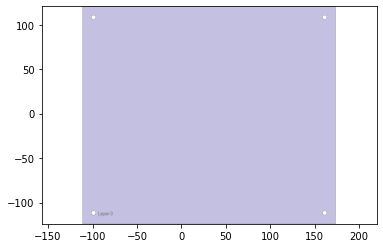

In [31]:
supported_design = web|design|support
supported_design.plot()

Plotting cut material final cut.

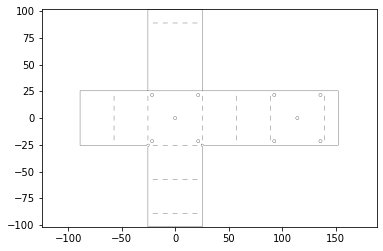

In [32]:
cut_material = (keepout<<kerf)-keepout
cut_material.plot()

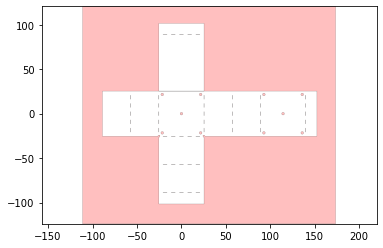

In [33]:
final_cut = sheet - keepout
final_cut = final_cut[0]
final_cut.plot()

Plotting remaining material.

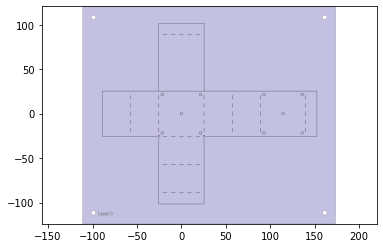

In [34]:
remaining_material = supported_design-cut_material
remaining_material.plot()

Plotting pieces resulting from cuts.

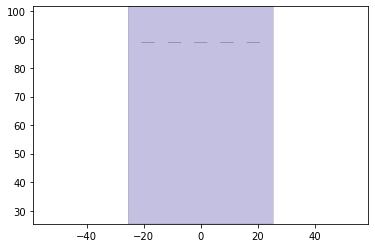

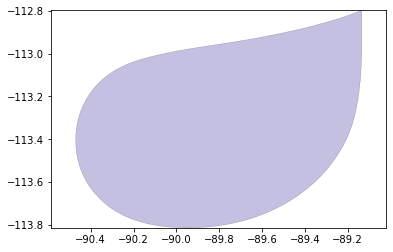

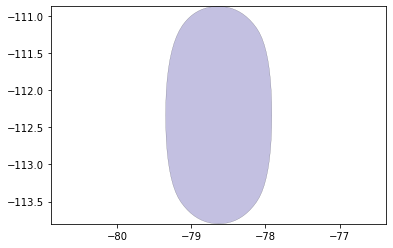

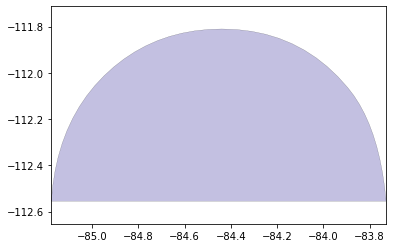

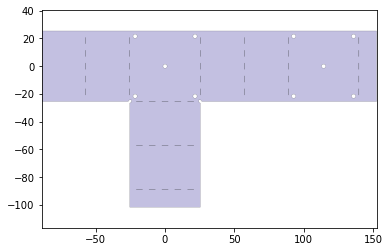

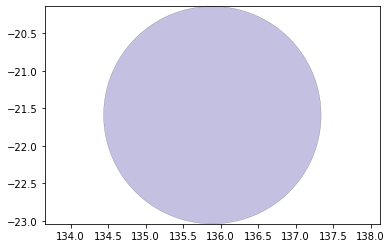

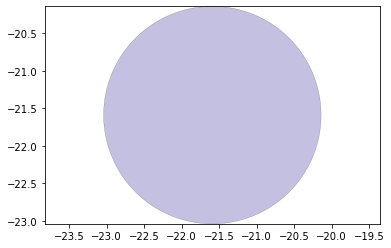

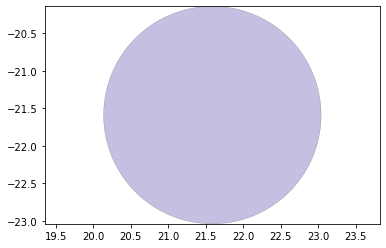

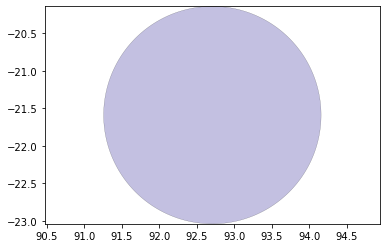

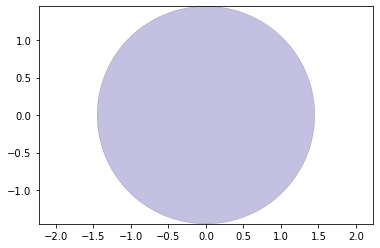

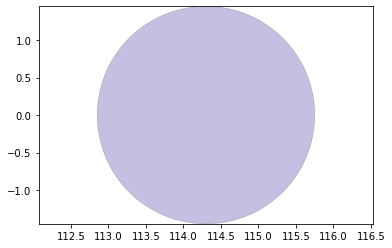

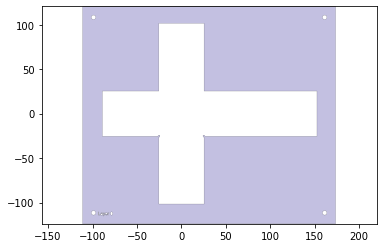

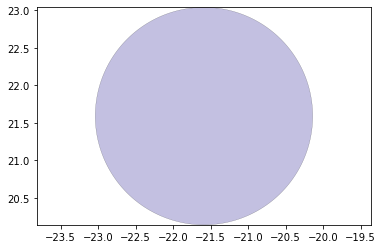

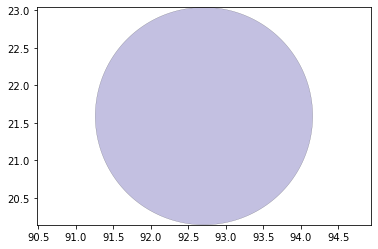

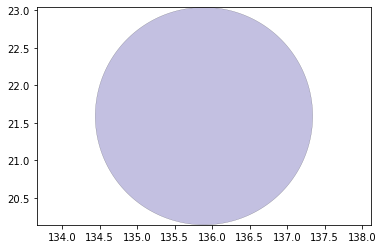

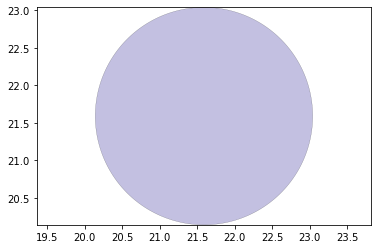

In [35]:
remaining_parts = foldable_robotics.manufacturing.find_connected(remaining_material,is_adhesive1)
for item in remaining_parts:
    item.plot(new=True)

In [36]:
d3=design>>1
for item in remaining_parts:
    if not (item&d3).is_null():
        break
check = (item^design)
print(check.is_null())

False


Exporting 1-layer dxf.

In [37]:
final_cut.export_dxf('single_layer_cut')

4. Using a 5-layer design approach, compute the same design of your device in five layers, plotting each step along the way. This should include: a five-layer hinge design that fits your team’s need (with justification for material used, rotational needs, manufacturing method used, etc), mapping the hinge design to each joint in your joints layer of the dxf, subtracting the 5-layer hinge design from the body laminate, holes computed for any vertices.

Generating a 5 layer castellated hinge.

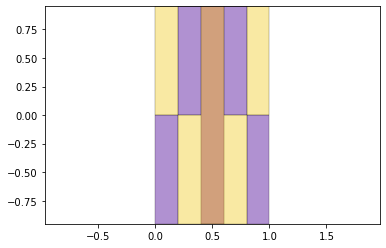

In [38]:
hinge = foldable_robotics.parts.castellated_hinge1.generate()
w=hinge_width_calculator(150,1.1)
hinge = hinge.scale(1,w)
hinge.plot()

In [39]:
NUMLAYERS = len(hinge)
NUMLAYERS

5

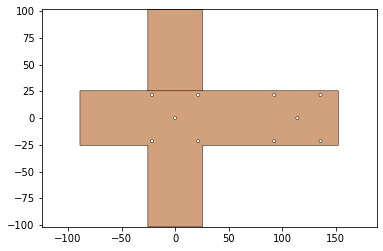

In [40]:
body = get_bodies(output_file_name,'body',NUMLAYERS)
body = foldable_robotics.manufacturing.cleanup(body,.01)
body.plot()

Mapping hinge design.

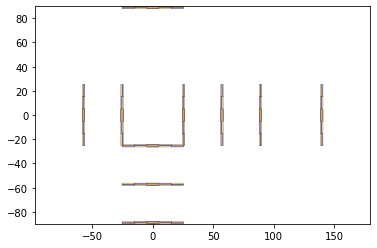

In [41]:
joint_lines= get_hinge_lines(output_file_name,'joints')
joints = hinge_lines_to_hinges(joint_lines,hinge)
joints = foldable_robotics.manufacturing.cleanup(joints,.02)
joints.plot()

In [42]:
cuts = get_cuts(output_file_name,'cuts',.02,NUMLAYERS)

In [43]:
holes = get_holes(output_file_name,'holes',NUMLAYERS)

Computting holes.

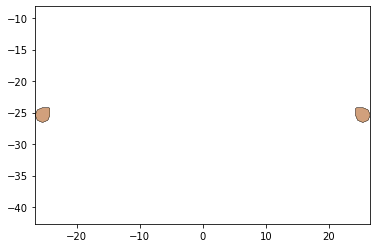

In [44]:
hole,dummy = foldable_robotics.manufacturing.calc_hole(joint_lines,w)
hole = hole.to_laminate(NUMLAYERS)
hole<<=.2
hole.plot()

5. Using the full design pipeline found on the website and discussed in class, compute the manufacturing geometry for a five-layer laminate, plotting each step along the way. This should include: web design, support design, non-removable scrap, connection check of all parts that result from the second-pass cut, and similarity check between design and removed final part.

Subtracting hole, cut, and joint geometries from the body.

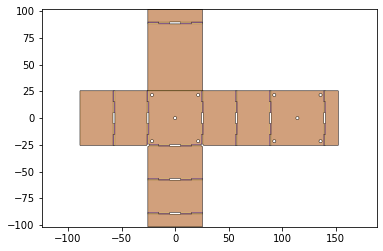

In [45]:
design = body- hole - joints - cuts - holes
design.plot()

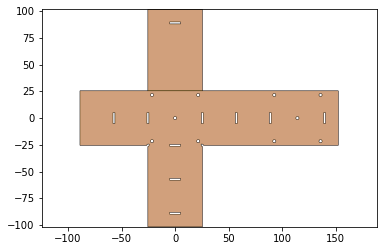

In [46]:
keepout =  foldable_robotics.manufacturing.keepout_laser(design)
keepout.plot()

Web design

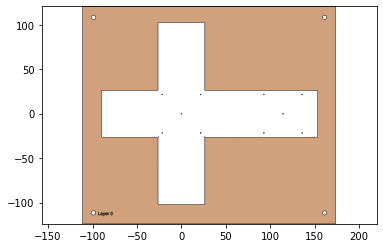

In [47]:
web,sheet=build_web(design,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive)
web.plot()

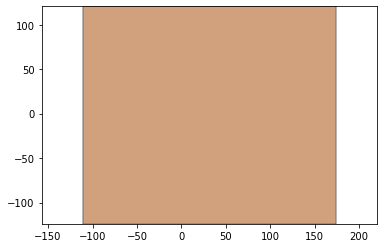

In [48]:
sheet.plot()

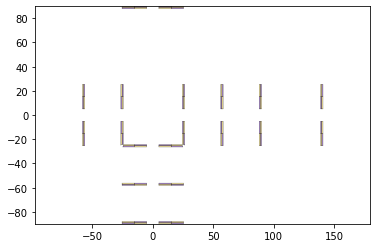

In [49]:
second_pass_scrap = sheet-keepout
first_pass_scrap = sheet - design-second_pass_scrap
first_pass_scrap = foldable_robotics.manufacturing.cleanup(first_pass_scrap,.00001)
first_pass_scrap.plot()

Support design.

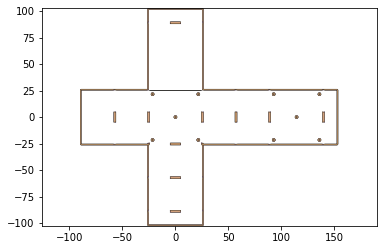

In [50]:
support = foldable_robotics.manufacturing.support(design,foldable_robotics.manufacturing.keepout_laser,support_width,support_width/2)
support.plot()

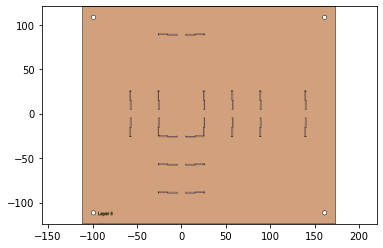

In [51]:
supported_design = web|design|support
supported_design.plot()

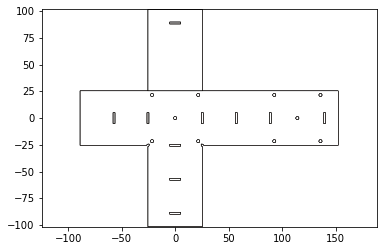

In [52]:
cut_material = (keepout<<kerf)-keepout
cut_material.plot()

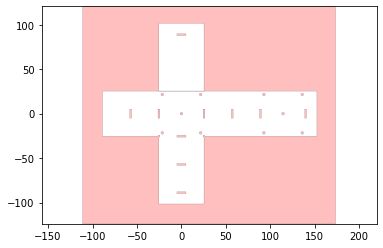

In [53]:
final_cut = sheet - keepout
final_cut = final_cut[0]
final_cut.plot()

Full cut.

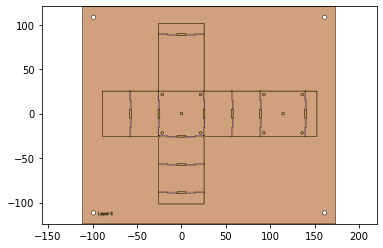

In [54]:
remaining_material = supported_design-cut_material
remaining_material.plot()

Connection check.

C:\Anaconda3\lib\site-packages\foldable_robotics\laminate.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


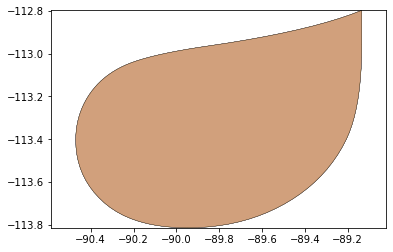

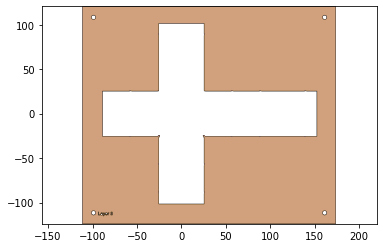

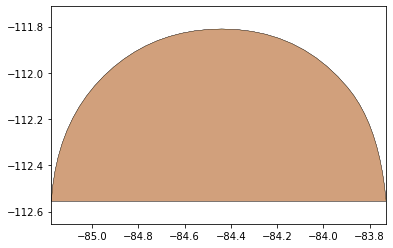

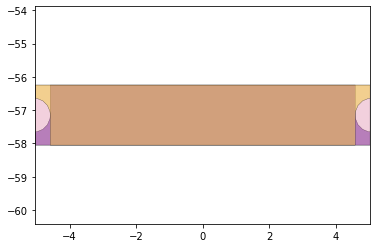

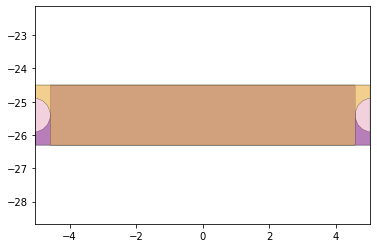

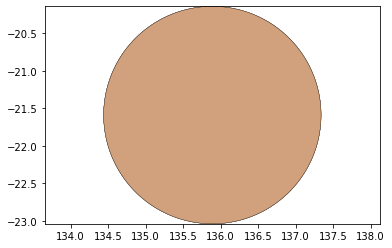

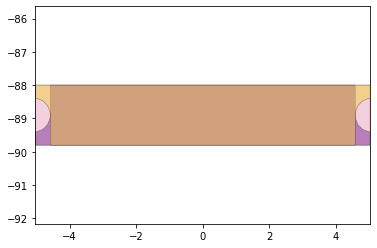

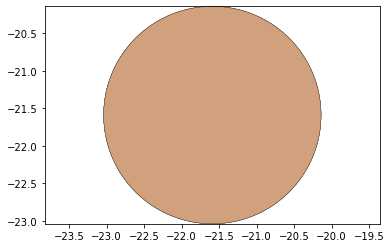

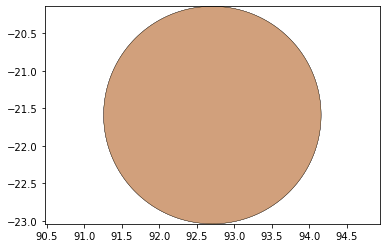

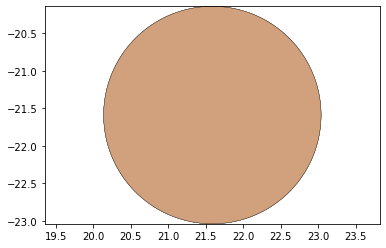

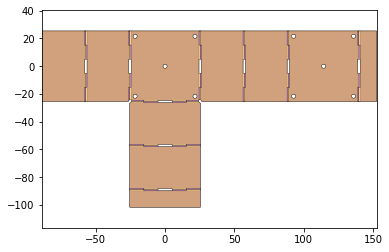

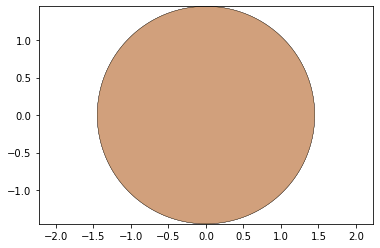

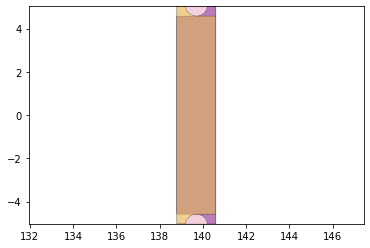

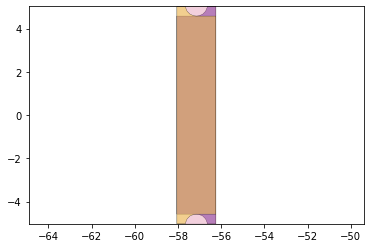

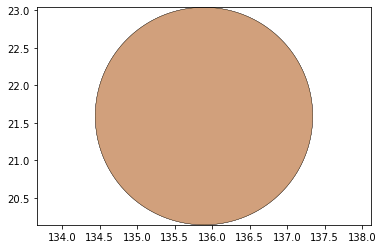

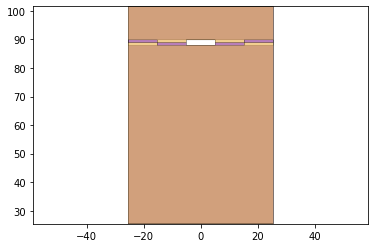

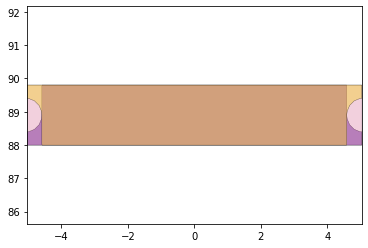

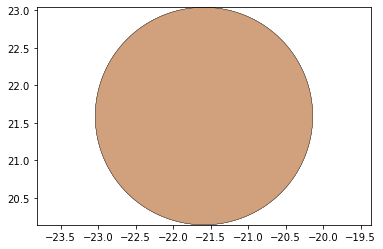

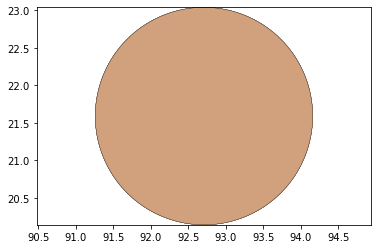

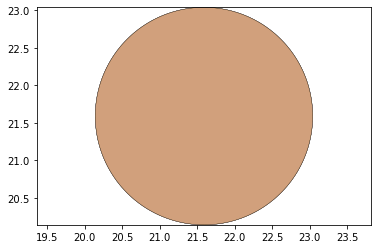

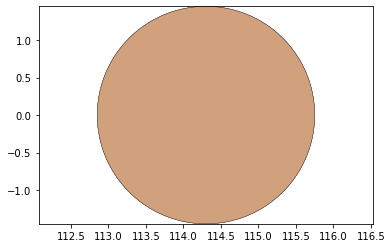

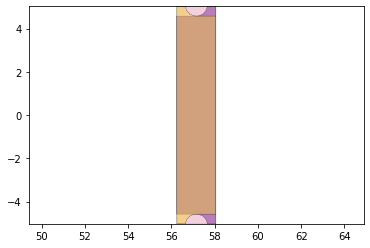

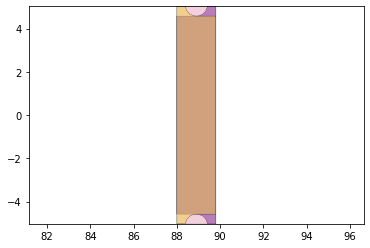

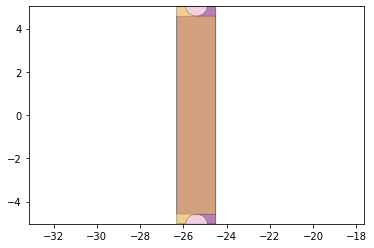

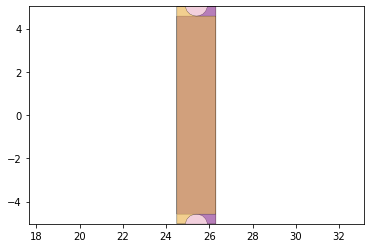

In [55]:
remaining_parts = foldable_robotics.manufacturing.find_connected(remaining_material,is_adhesive)
for item in remaining_parts:
    item.plot(new=True)

In [56]:
d3=design>>1
for item in remaining_parts:
    if not (item&d3).is_null():
        break
check = (item^design)
print(check.is_null())

False


In [57]:
if check.is_null():
    supported_design.export_dxf('first_pass')
    final_cut.export_dxf('second_pass')
    


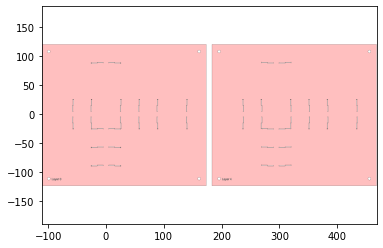

In [58]:
w,h = supported_design.get_dimensions()
p0,p1 = supported_design.bounding_box_coords()

rigid_layer = supported_design[0] | (supported_design[-1].translate(w+10,0))
rigid_layer.plot()

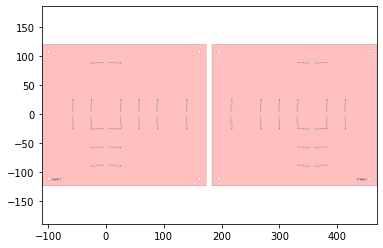

In [59]:
l4 = supported_design[3].scale(-1,1)
p2,p3 = l4.bounding_box_coords()
l4 = l4.translate(p0[0]-p2[0]+10+w,p0[1]-p2[1])

adhesive_layer = supported_design[1] | l4
adhesive_layer.plot()

In [60]:
first_pass = Laminate(rigid_layer,adhesive_layer,supported_design[2])
if check.is_null():
    first_pass.export_dxf('first_pass')
    final_cut.export_dxf('final_cut')

In [61]:
check.is_null()

False

Exporting 5-layer DXFs:

In [62]:
rigid_layer.export_dxf('rigid_layer')
adhesive_layer.export_dxf('adhesive_layer')
final_cut.export_dxf('final_cut')

6. Export your final cut files to .dxf or .pdf, depending on your need. You should export one file per layer as well as one final cut file(if using a laminate process).

![](https://drive.google.com/uc?export=view&id=1eAjMtAMA1WtnvtoRONltmoouwO0kDXGc)

<h0><center>**Figure 6a: Single-Layer .dxf File**</center></h0>

![](https://drive.google.com/uc?export=view&id=1U5vZSmv7uNjHHDBDrjOgyyr9px9UelMn)

<h0><center>**Figure 6b: Five-Layer Adhesive .dxf File**</center></h0>

![](https://drive.google.com/uc?export=view&id=1GjR_hsVQBlxLJSutQzukx6boUkBVkBV6)

<h0><center>**Figure 6c: Five-Layer Rigid .dxf File**</center></h0>

![](https://drive.google.com/uc?export=view&id=1viyfRq0g6BoDbpCgmxWuvjoKTdDBgIQ8)

<h0><center>**Figure 6d: Five-Layer Final .dxf File**</center></h0>